In [1]:
import time
import torch
import torchvision

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

from torchsummary import summary
from IPython.display import clear_output
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader

In [ ]:
SEED = 0xDEAD
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.random.manual_seed(SEED)
torch.cuda.random.manual_seed_all(SEED)

### Data

In [2]:
batch_size = 256

transform_train = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomResizedCrop(32, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform_train
)
testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

dataset_sizes = {"train": len(trainset), "test": len(testset)}

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

dataset_sizes

Files already downloaded and verified
Files already downloaded and verified


{'train': 50000, 'test': 10000}

In [3]:
for dataset_name, loader in [("Train", trainloader), ("Test", testloader)]:
    for images, _ in loader:
        batch_size, channels, height, width = images.size()

        if any((height != images.size(2), width != images.size(3))):
            print(f"{dataset_name} Images are not the same size: {height}x{width}")

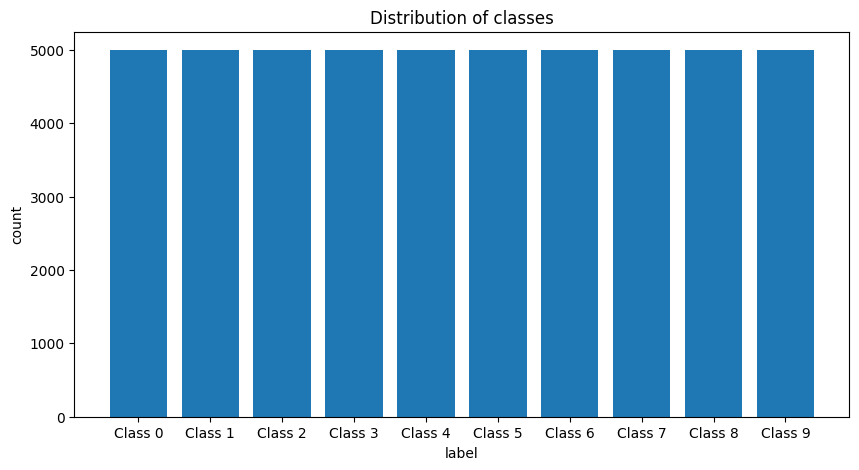

In [4]:
class_counts = [len(np.argwhere(np.array(trainset.targets) == i)) for i in range(10)]
class_labels = [f"Class {i}" for i in range(10)]

plt.figure(figsize=(10, 5))
plt.bar(class_labels, class_counts)
plt.xlabel("label")
plt.ylabel("count")
plt.title("Distribution of classes")
plt.show()

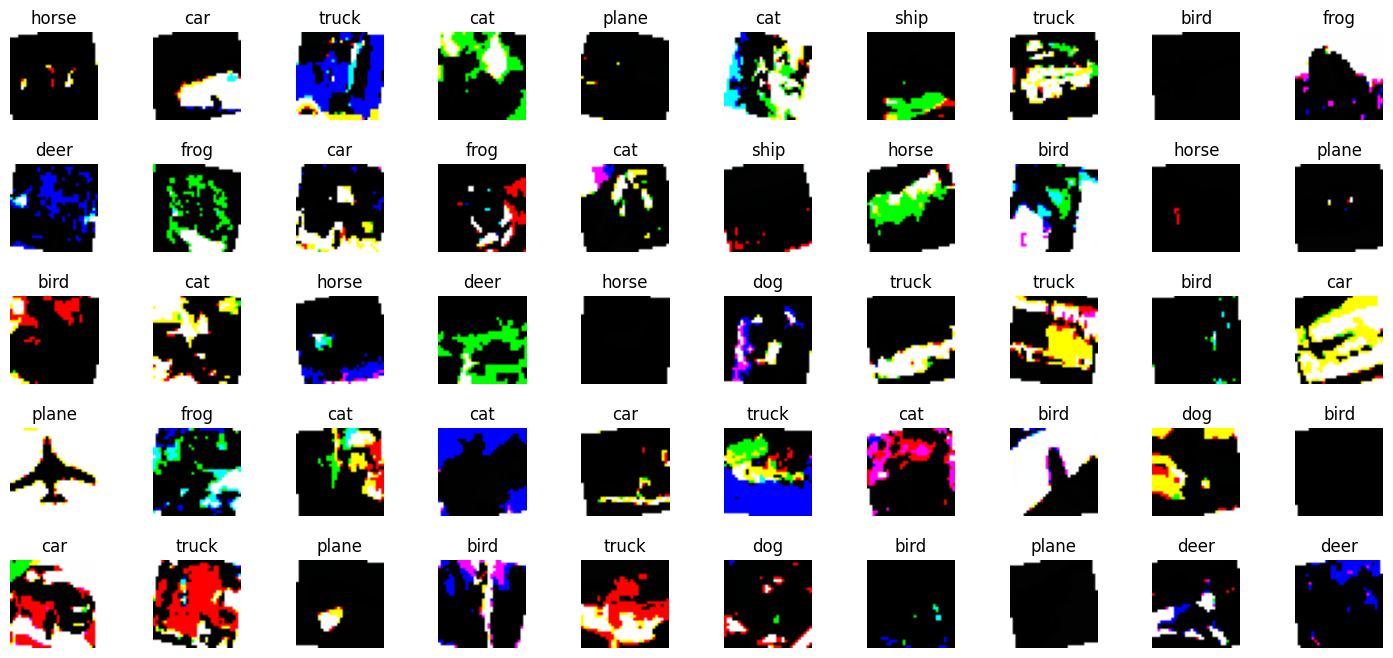

In [5]:
def imshow_grid(images, labels, rows, cols):
    _, axes = plt.subplots(rows, cols, figsize=(18, 8))

    for i in range(rows):
        for j in range(cols):
            index = i * cols + j
            img = images[index].permute(1, 2, 0).numpy().astype("uint8")

            axes[i, j].imshow(img)
            axes[i, j].axis("off")
            axes[i, j].set_title(classes[labels[index]])

    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    plt.show()


images, labels = next(iter(trainloader))
imshow_grid(images, labels, rows=5, cols=10)

### Utils

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
def plot_training_progress(
    train_loss_history, test_loss_history, train_accuracy_history, test_accuracy_history
):
    clear_output(wait=True)

    epoch = len(train_loss_history) - 1

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, "-x", label="train")
    plt.plot(test_loss_history, "-x", label="test")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.title("Loss")
    plt.grid(linewidth=0.1)

    current_train_loss = train_loss_history[-1]
    current_test_loss = test_loss_history[-1]

    plt.text(epoch, current_train_loss, f"{current_train_loss:.3f}", va="center", ha="right")
    plt.text(len(test_loss_history) - 1, current_test_loss, f"{current_test_loss:.3f}", va="center", ha="right",)

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_history, "-x", label="train")
    plt.plot(test_accuracy_history, "-x", label="test")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.title("Accuracy")
    plt.grid(linewidth=0.1)

    current_train_accuracy = train_accuracy_history[-1]
    current_test_accuracy = test_accuracy_history[-1]

    plt.text(epoch, current_train_accuracy, f"{current_train_accuracy:.2f}%", va="center", ha="right",)
    plt.text(epoch, current_test_accuracy, f"{current_test_accuracy:.2f}%", va="center", ha="right",)

    plt.tight_layout()
    plt.show()

In [8]:
def train_one_epoch(model, trainloader, criterion, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
            
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    scheduler.step()

    return total_loss / len(trainloader), 100 * correct / total_samples

In [9]:
def evaluate(model, testloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            correct += (predicted == labels).sum().item()

    return total_loss / len(testloader), (correct / total_samples) * 100

In [10]:
def train_and_evaluate(
    model, trainloader, testloader, criterion, optimizer, scheduler, num_epochs
):
    train_loss_history = []
    test_loss_history = []
    train_accuracy_history = []
    test_accuracy_history = []
    epoch_times = []

    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss, train_accuracy = train_one_epoch(
            model, trainloader, criterion, optimizer, scheduler, device
        )
        test_loss, test_accuracy = evaluate(model, testloader, criterion, device)
        end_time = time.time()

        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)
        train_accuracy_history.append(train_accuracy)
        test_accuracy_history.append(test_accuracy)
        epoch_times.append(end_time - start_time)

        plot_training_progress(
            train_loss_history,
            test_loss_history,
            train_accuracy_history,
            test_accuracy_history,
        )

        print(
            "Epoch {} Epoch Time: {:.2f} sec.\n"
            "Train Loss: {:.3f} Train Accuracy: {:.2f}%\n"
            "Test Loss: {:.3f} Test Accuracy: {:.2f}%".format(
                epoch + 1,
                epoch_times[-1],
                train_loss,
                train_accuracy,
                test_loss,
                test_accuracy,
            )
        )

    total_training_time = sum(epoch_times)
    avg_epoch_time = total_training_time / num_epochs

    print(
        f"Total train time: {total_training_time:.2f} sec.\n"
        f"Average epoch time: {avg_epoch_time:.2f} sec."
    )

    return (
        train_loss_history,
        train_accuracy_history,
        test_loss_history,
        test_accuracy_history,
    )

### Model

In [11]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000, dropout=0.0):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


m_AlexNet = AlexNet(10, 0.55).to(device)
input_size = (3, 32, 32)
summary(m_AlexNet, input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 192, 16, 16]         110,784
              ReLU-5          [-1, 192, 16, 16]               0
         MaxPool2d-6            [-1, 192, 8, 8]               0
            Conv2d-7            [-1, 384, 8, 8]         663,936
              ReLU-8            [-1, 384, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         884,992
             ReLU-10            [-1, 256, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         590,080
             ReLU-12            [-1, 256, 8, 8]               0
        MaxPool2d-13            [-1, 256, 4, 4]               0
AdaptiveAvgPool2d-14            [-1, 25

### Train and evaluate

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(m_AlexNet.parameters(), lr=1e-1, momentum=0.95, weight_decay=1e-3)
scheduler = lr_scheduler.StepLR(optimizer, step_size=9, gamma=0.5)
num_epochs = 100

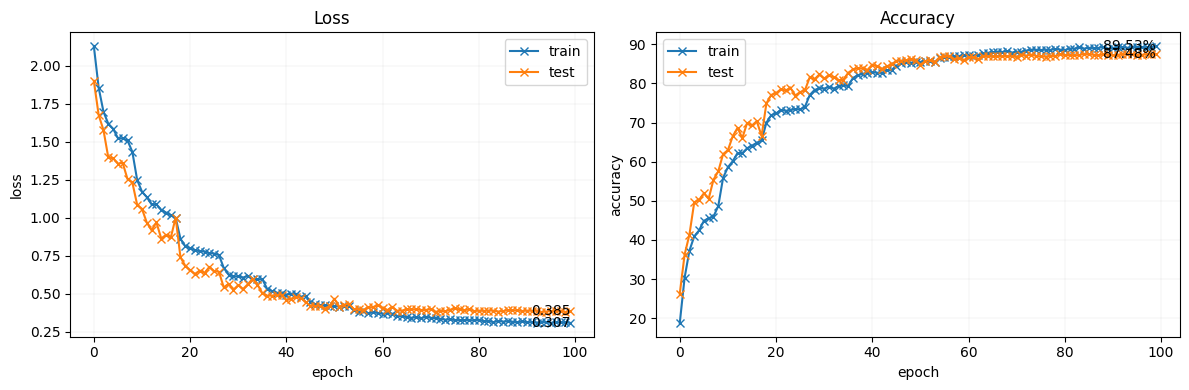

Epoch 100 Epoch Time: 12.62 sec.
Train Loss: 0.307 Train Accuracy: 89.53%
Test Loss: 0.385 Test Accuracy: 87.48%
Total train time: 1325.75 sec.
Average epoch time: 13.26 sec.


In [13]:
results = train_and_evaluate(
    m_AlexNet,
    trainloader,
    testloader,
    criterion,
    optimizer,
    scheduler,
    num_epochs,
)

### Results

In [16]:
results_df = pd.DataFrame(results)
results_df = results_df.drop([0, 2]) # drop train/test losses
results_df_max = results_df.max(axis=1)
results_df_max

1    89.53
3    87.57
dtype: float64

In [17]:
results_df_max.to_csv("pw1_results.csv", index=False)

### Conclusions